# My First CNN on MNIST

## 일단 Quick 하게!!

코드는 정말 수루룩 끝난다!

그래서 다시 한 번! 다음 그림을 보고 구조를 확실히 추적할 수 있어야 한다.

* [Ex1](https://cdn-images-1.medium.com/max/1600/1*O9ulXVmjBustHGLi1zRthA.png)
* [Ex2](https://cdn-images-1.medium.com/max/1600/1*jqKHgwZ8alM3K_JRYO_l4w.png)



### 라이브러리 로딩

In [1]:
'''
matplolib inline 명령어를 통해서
matplot으로 그리는 플롯들을 주피터 노트북 내에서 볼 수 있게 해준다.
포맷을 retina로 바꾸면 그래프의 화질이 훨씬 좋아진다.
'''
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

'''
라이브러리들을 불러오자.
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras import layers, models
from tensorflow.keras import backend

import random as rd
from sklearn.metrics import accuracy_score

In [2]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

In [3]:
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


id = 2432
다음 그림은 숫자 2 입니다.


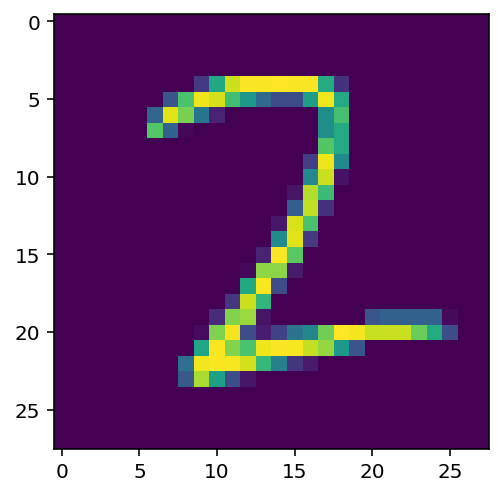

In [4]:
'''
Ctrl+Enter를 이용하여
반복 실행 해보자!
'''

id = rd.randrange(0, 10000)

print(f'id = {id}')
print(f'다음 그림은 숫자 {test_y[id]} 입니다.')
plt.imshow(test_x[id])
plt.show()

### Convolutional Layer를 사용하기 위한 reshape!

- **채널이 추가되어야 한다**

In [5]:
train_x.shape, test_x.shape

((60000, 28, 28), (10000, 28, 28))

In [6]:
_, h, w = train_x.shape

print(h, w)

28 28


In [7]:
train_x = train_x.reshape(-1, h, w, 1)
test_x = test_x.reshape(-1, h, w, 1)

In [8]:
train_x.shape

(60000, 28, 28, 1)

* 이미지가 0 ~ 1 사이 값을 갖도록 스케일 조정!

In [9]:
max_n, min_n = train_x.max(), train_x.min()

In [10]:
train_x = (train_x - min_n) / (max_n - min_n)
test_x = (test_x - min_n) / (max_n - min_n)

In [11]:
train_x.max(), train_x.min()

(1.0, 0.0)

In [18]:
# train_y.shape

(60000,)

In [19]:
# from tensorflow.keras.utils import to_categorical

In [20]:
# train_y = to_categorical(train_y, 10)
# test_y = to_categorical(test_y, 10)

In [12]:
train_x.shape, train_y.shape

((60000, 28, 28, 1), (60000,))

## Sequential API로 모델링

CNN에 관한 것만 추가가 된다.
[여기](https://keras.io/layers/convolutional/)를 적극적으로 참고하자

- (Con, Con, Maxpool, BatchNorm, Dropout) * 2

In [14]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Dropout, Conv2D, MaxPool2D

In [15]:
# 1. 세션 클리어
clear_session()

# 2. 모델 발판 생성
model = Sequential()

# 3. 레이어 블록 조립
model.add( Input(shape=(28,28,1)) )
model.add( Conv2D(filters=32,           # feature map의 수
                  kernel_size=(3,3),    # filter size
                  strides=(1,1),        # 훑는 방식 결정
                  padding='same',       # 0을 덧댄다
                  activation='relu') )  # activation 주의!

model.add( Conv2D(filters=32,         
                  kernel_size=(3,3),    
                  strides=(1,1),       
                  padding='same',      
                  activation='relu') )  

model.add( MaxPool2D(pool_size=(2,2)) ) # feature map 사이즈 절반으로 줄이기! <- (2,2)의 값 중 가장 높은 것으로
model.add( BatchNormalization() )       # 모델 학습에 유용한 레이어
model.add( Dropout(0.2) )               # 학습 과정에서 노드 일부를 일부러 제외한다

model.add( Conv2D(filters=64,           
                  kernel_size=(3,3),    
                  strides=(1,1),      
                  padding='same',       
                  activation='relu') )  
model.add( Conv2D(filters=64,           
                  kernel_size=(3,3),    
                  strides=(1,1),        
                  padding='same',       
                  activation='relu') ) 

model.add( MaxPool2D(pool_size=(2,2)) )
model.add( BatchNormalization() )       
model.add( Dropout(0.2) )

model.add( Flatten() )
model.add( Dense(128, activation='relu') )
model.add( Dense(10, activation='softmax') )

# 4. 컴파일
model.compile(loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'],
              optimizer='adam')

# 요약
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1

In [16]:
# 데이터를 넣어서 학습시키자!
history = model.fit(train_x, train_y, epochs=15, batch_size=1024,
                    validation_split=0.2, verbose=1)

Epoch 1/15
47/47 [==============================] - 8s 98ms/step - loss: 0.4364 - accuracy: 0.8742 - val_loss: 2.0837 - val_accuracy: 0.1402
Epoch 2/15
47/47 [==============================] - 3s 61ms/step - loss: 0.0688 - accuracy: 0.9788 - val_loss: 2.3453 - val_accuracy: 0.1217
Epoch 3/15
47/47 [==============================] - 3s 62ms/step - loss: 0.0434 - accuracy: 0.9860 - val_loss: 2.6123 - val_accuracy: 0.1086
Epoch 4/15
47/47 [==============================] - 3s 62ms/step - loss: 0.0339 - accuracy: 0.9899 - val_loss: 2.8091 - val_accuracy: 0.1277
Epoch 5/15
47/47 [==============================] - 3s 62ms/step - loss: 0.0260 - accuracy: 0.9914 - val_loss: 2.7910 - val_accuracy: 0.1653
Epoch 6/15
47/47 [==============================] - 3s 62ms/step - loss: 0.0215 - accuracy: 0.9933 - val_loss: 2.6364 - val_accuracy: 0.1542
Epoch 7/15
47/47 [==============================] - 3s 62ms/step - loss: 0.0175 - accuracy: 0.9944 - val_loss: 1.5259 - val_accuracy: 0.4201
Epoch 8/15
47

In [17]:
performance_test = model.evaluate(test_x, test_y, batch_size=100)

print(f'Test Loss : {performance_test[0]:.6f},  Test Accuracy : {performance_test[1]*100:.3f}%')

100/100 [==============================] - 1s 4ms/step - loss: 0.0238 - accuracy: 0.9932
Test Loss : 0.023758,  Test Accuracy : 99.320%


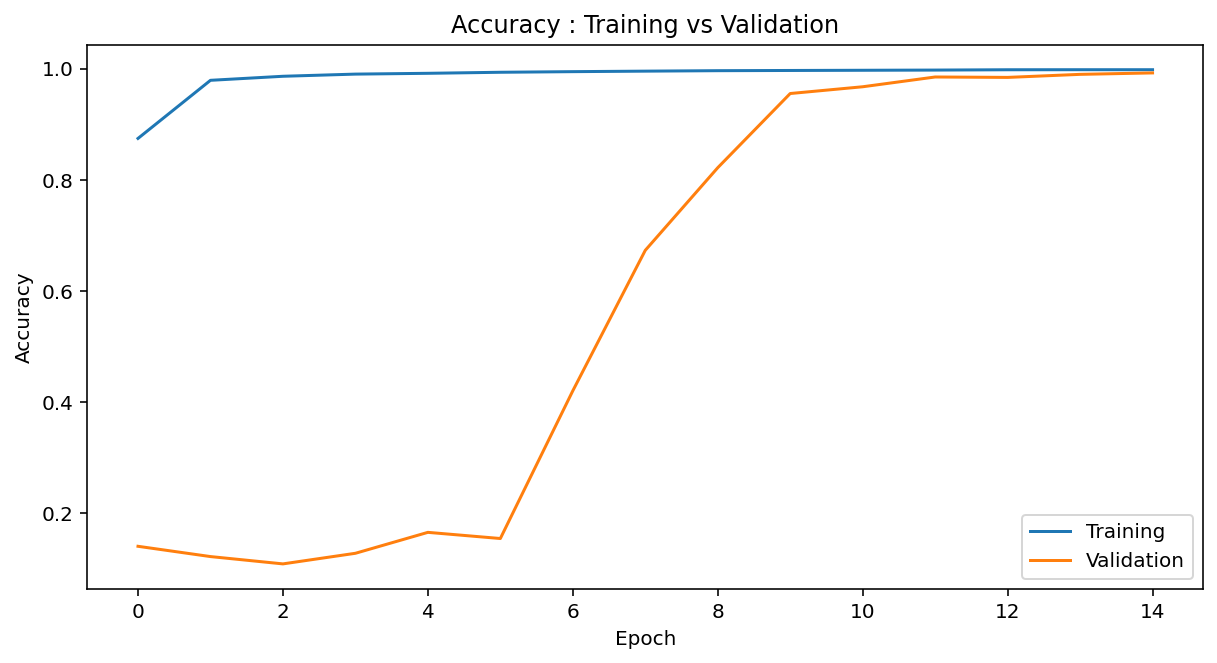

In [18]:
if not isinstance(history, dict) :
    history = history.history

plt.figure(figsize=(10, 5))
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy : Training vs Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

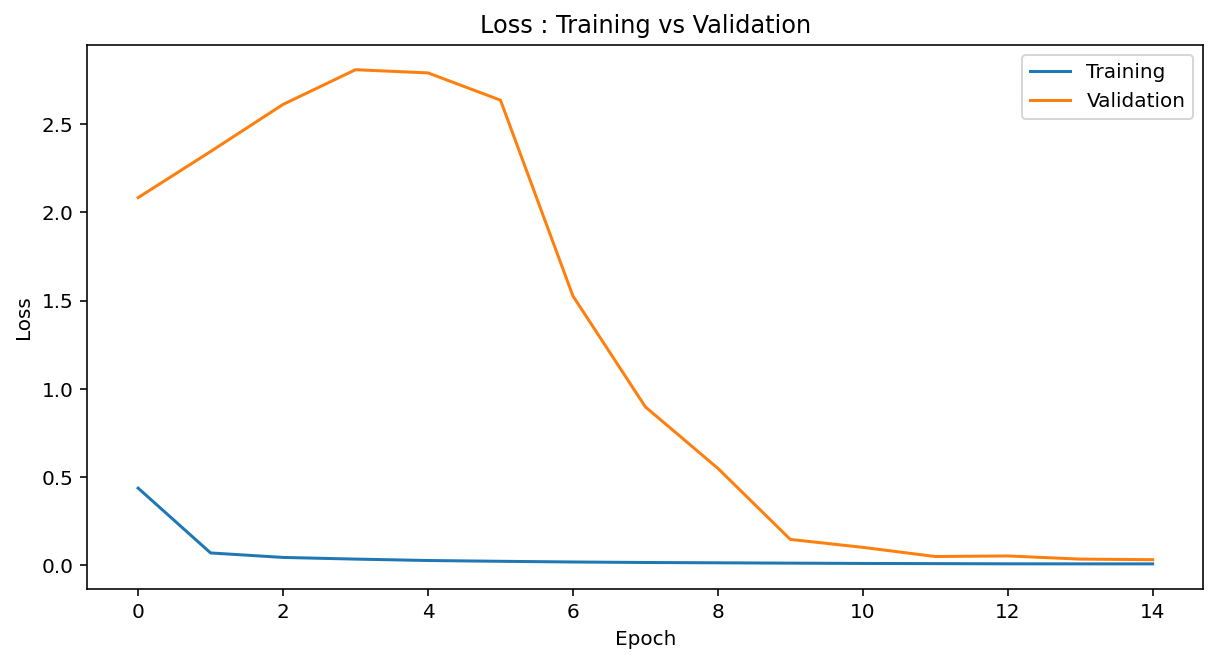

In [21]:
if not isinstance(history, dict) :
    history = history.history

plt.figure(figsize=(10, 5))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss : Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

* 예측값 생성

In [20]:
pred_train = model.predict(train_x)
pred_test = model.predict(test_x)

single_pred_train = pred_train.argmax(axis=1)
single_pred_test = pred_test.argmax(axis=1)

logi_train_accuracy = accuracy_score(train_y, single_pred_train)
logi_test_accuracy = accuracy_score(test_y, single_pred_test)

print('CNN')
print('트레이닝 정확도 : {:.2f}%'.format(logi_train_accuracy*100))
print('테스트 정확도 : {:.2f}%'.format(logi_test_accuracy*100))

CNN
트레이닝 정확도 : 99.78%
테스트 정확도 : 99.32%


## 숫자 이미지 시각화

id = 316
다음 그림은 숫자 6 입니다.
모델의 예측 : 6
모델의 카테고리별 확률 : [ 0.  0.  0.  0.  0.  0. 99.  0.  0.  0.]
정답입니다


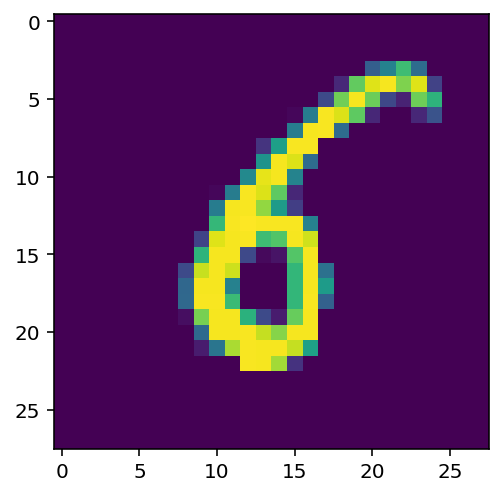

In [22]:
'''
성능 확인을 위해
Ctrl+Enter를 이용하여
반복 실행 해보자!
'''

id = rd.randrange(0,10000)

print(f'id = {id}')
print(f'다음 그림은 숫자 {test_y[id]} 입니다.')
print(f'모델의 예측 : {single_pred_test[id]}')
print(f'모델의 카테고리별 확률 : {np.floor(pred_test[id]*100)}')

if test_y[id] == single_pred_test[id] :
    print('정답입니다')
else : 
    print('틀렸어요')
plt.imshow(test_x[id].reshape([28,-1]))
plt.show()

id = 8316
다음 그림은 숫자 7 입니다.
모델의 예측 : 2
모델의 카테고리별 확률 : [ 0.  0. 52.  0.  0.  0.  0. 47.  0.  0.]
틀렸어요


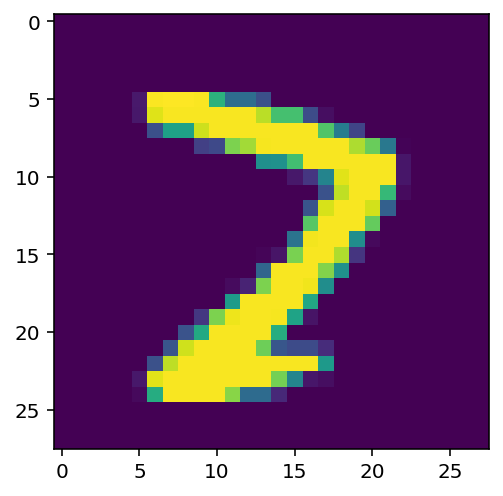

In [26]:
'''
틀린 것만 관찰해보자!

Ctrl+Enter를 이용하여
반복 실행 해보자!
'''

true_false = (test_y==single_pred_test)
f_id = np.where(true_false==False)[0]
f_n = len(f_id)

id = f_id[rd.randrange(0,f_n)]

print(f'id = {id}')
print(f'다음 그림은 숫자 {test_y[id]} 입니다.')
print(f'모델의 예측 : {single_pred_test[id]}')
print(f'모델의 카테고리별 확률 : {np.floor(pred_test[id]*100)}')

if test_y[id] == single_pred_test[id] :
    print('정답입니다')
else : 
    print('틀렸어요')
plt.imshow(test_x[id].reshape([28,-1]))
plt.show()